In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iyzico-datathon/sample_submission.csv
/kaggle/input/iyzico-datathon/train.csv


In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:
###############################################################
# Görev 1 : Veri Setinin Keşfi
###############################################################

df = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")


df['month_id'] = pd.to_datetime(df['month_id'], format='%Y%m')

df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,2023-07-01,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,2023-01-01,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,2023-05-01,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,2023-08-01,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,2023-02-01,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,2023-09-01,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,2023-09-01,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,2023-09-01,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,2023-09-01,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [31]:

df['merchant_id'] = df['merchant_id'].apply(lambda x: x.split('_')[1]).astype(np.uint64)
df['merchant_source_name'] = df['merchant_source_name'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['settlement_period'] = df['settlement_period'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['working_type'] = df['working_type'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)
df['mcc_id'] = df['mcc_id'].apply(lambda x: x.split('_')[1]).astype(np.uint8)
df['merchant_segment'] = df['merchant_segment'].apply(lambda x: x.split('-')[1].strip()).astype(np.uint8)

In [32]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,43992,2023-07-01,3,3,2,197,2,15106
1,43992,2023-01-01,3,3,2,197,2,16918
2,43992,2023-05-01,3,3,2,197,2,13452
3,43992,2023-08-01,3,3,2,197,2,16787
4,43992,2023-02-01,3,3,2,197,2,12428
...,...,...,...,...,...,...,...,...
291137,67083,2023-09-01,1,1,6,169,4,4
291138,4263,2023-09-01,2,1,6,73,4,4
291139,11346,2023-09-01,1,1,6,169,4,3
291140,21397,2023-09-01,1,1,6,168,4,3


import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Zaman serisi ayrıştırması için df veri çerçevesi ve net_payment_count sütunu kullanılacak
decomposed_net_payment = sm.tsa.seasonal_decompose(df["net_payment_count"], period=12)  # Aylık veriler olduğu için mevsimsellik için 12 dönem seçtik

# Ayrıştırılmış bileşenleri görselleştirme
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
ax1.set_title('Zaman Serisi Ayrıştırması')
decomposed_net_payment.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Gözlemlenen')
decomposed_net_payment.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decomposed_net_payment.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Mevsimsellik')
decomposed_net_payment.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Artıklar')

plt.show()

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Veri çerçevesindeki "net_payment_count" sütununu kullanarak PACF analizi yapma
time_series = df["net_payment_count"]

# PACF analizini çizdirme
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(time_series, ax=ax, lags=48)
ax.set_xlabel("Gecikme")
ax.set_ylabel("PACF")
ax.set_title("Kısmi Otokorelasyon Fonksiyonu (PACF)")
plt.show()

import plotly.express as px

# Calculate daily total production
total = df.set_index('month_id').groupby(pd.Grouper(freq='D')).sum().reset_index()

# Plotly line chart
fig = px.line(total, x="month_id", y="net_payment_count", labels={"net_payment_count": "Total Payment"})
fig.update_layout(
    title="Total Payment by Date",
    xaxis_title="Date",
    yaxis_title="Total Payment"
)
fig.show()

In [33]:
###############################################################
# Görev 2 : Feature Engineering
###############################################################

########################
# Date Features
########################

def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    #df['day_of_month'] = df[date_column].dt.day
    #df['day_of_year'] = df[date_column].dt.dayofyear
    
    #df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    #df["is_wknd"] = df[date_column].dt.weekday // 4
    #df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    #df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    #df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    #df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    #df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
   # df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df, "month_id")
df.head()





,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,quarter
0,43992,2023-07-01,3,3,2,197,2,15106,7,2023,3
1,43992,2023-01-01,3,3,2,197,2,16918,1,2023,1
2,43992,2023-05-01,3,3,2,197,2,13452,5,2023,2
3,43992,2023-08-01,3,3,2,197,2,16787,8,2023,3
4,43992,2023-02-01,3,3,2,197,2,12428,2,2023,1


In [34]:
df['year_cyclic_sin'] = np.sin(2 * np.pi * df['year'] / 12)
df['year_cyclic_cos'] = np.cos(2 * np.pi * df['year'] / 12)

In [35]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,quarter,year_cyclic_sin,year_cyclic_cos
0,43992,2023-07-01,3,3,2,197,2,15106,7,2023,3,-0.5000,-0.8660
1,43992,2023-01-01,3,3,2,197,2,16918,1,2023,1,-0.5000,-0.8660
2,43992,2023-05-01,3,3,2,197,2,13452,5,2023,2,-0.5000,-0.8660
3,43992,2023-08-01,3,3,2,197,2,16787,8,2023,3,-0.5000,-0.8660
4,43992,2023-02-01,3,3,2,197,2,12428,2,2023,1,-0.5000,-0.8660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,67083,2023-09-01,1,1,6,169,4,4,9,2023,3,-0.5000,-0.8660
291138,4263,2023-09-01,2,1,6,73,4,4,9,2023,3,-0.5000,-0.8660
291139,11346,2023-09-01,1,1,6,169,4,3,9,2023,3,-0.5000,-0.8660
291140,21397,2023-09-01,1,1,6,168,4,3,9,2023,3,-0.5000,-0.8660


<Axes: >

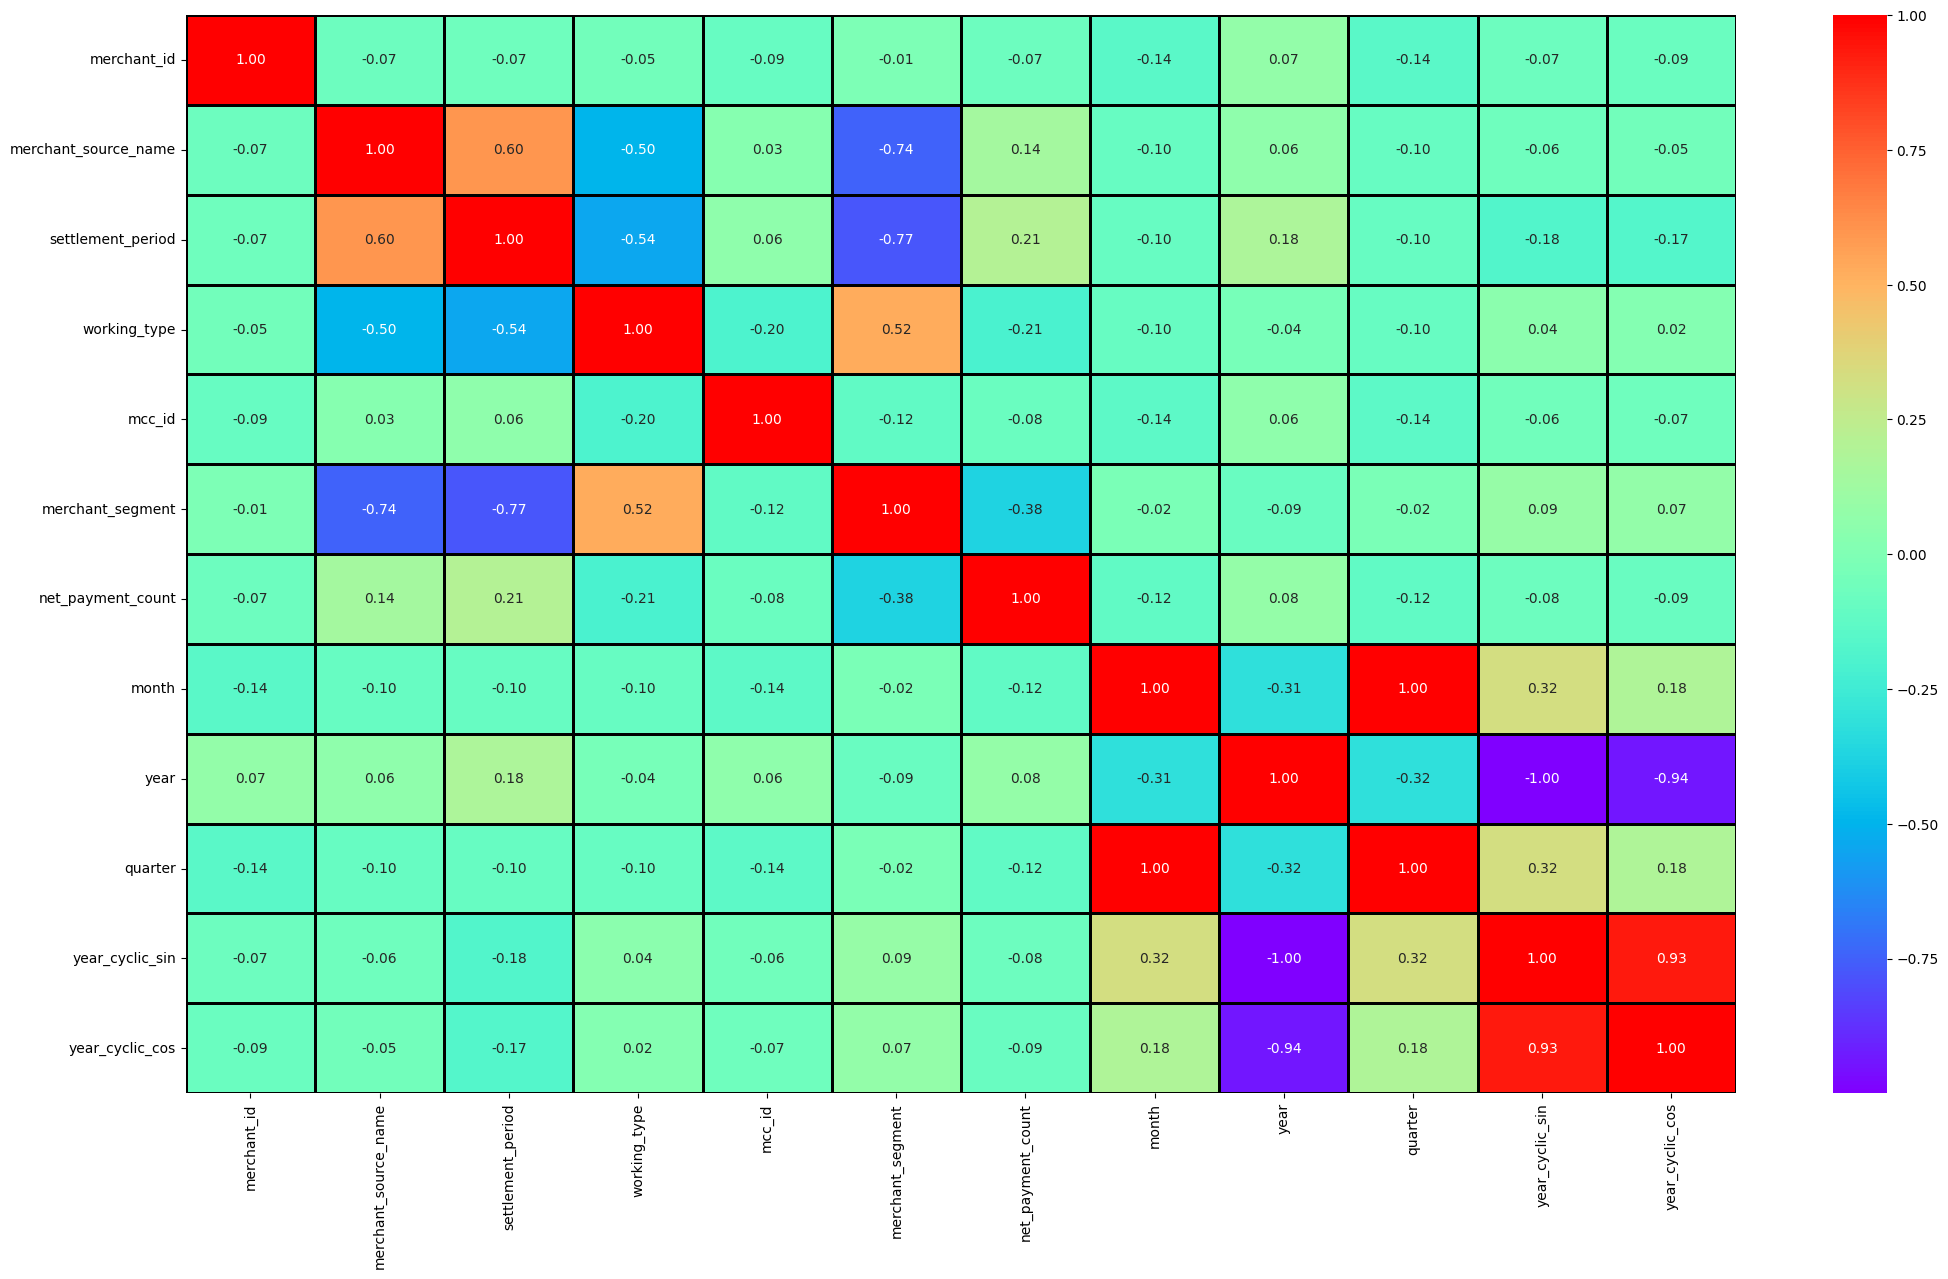

In [36]:
numeric_columns = df.select_dtypes(include=np.number)
correlation_matrix = numeric_columns.corr()
import seaborn as sns
plt.figure(figsize=(25, 14))
sns.heatmap(correlation_matrix.corr(), annot=True, cmap='rainbow', linewidth=1, linecolor='black', fmt='.2f')

In [37]:
class lag_lead_features:
    def lag_features(df:pd.DataFrame, columns, lags:int):
        """ Bu fonksiyon verilen veriseti, kolonlar ve lag değeri için gerekli düzenlemeyi gerçekleştirir.
        :param df: veri seti
        :param columns: Lag işlemi yapılmak istenen kolonlar
        :param lags: Yapılmak istenilen Lag sayısı      
        :return: d
        """
        for col in columns:
            for lag in range(lags):
                col_name = f"{col}_lagged_{lag}"
                df[col_name] = df[col].shift(lag)
        return df
        
    def lead_features(df, columns, lead):
        """ Bu fonksiyon verilen veriseti, kolonlar ve lead değeri için gerekli düzenlemeyi gerçekleştirir.
        :param df: veri seti
        :param columns: Lead işlemi yapılmak istenen kolonlar
        :param lags: Yapılmak istenilen lead sayısı      
        :return: 
        """
        for col in columns:
            for lag in range(lead):
                col_name = f"{col}_lead_{lag}"
                df[col_name] = df[col].shift(-lead)
        return df

df = lag_lead_features.lag_features(df, ["settlement_period","net_payment_count"], 8)
# Lead feature önceden bildiğimiz veriler olmalıdır(hava durumnu tahmin verileri)
# Power Generated kolonunu burada kullanamayız.
df = lag_lead_features.lead_features(df, ["merchant_source_name", "working_type"], 4)

In [38]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,...,net_payment_count_lagged_6,net_payment_count_lagged_7,merchant_source_name_lead_0,merchant_source_name_lead_1,merchant_source_name_lead_2,merchant_source_name_lead_3,working_type_lead_0,working_type_lead_1,working_type_lead_2,working_type_lead_3
0,43992,2023-07-01,3,3,2,197,2,15106,7,2023,...,NaN,NaN,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
1,43992,2023-01-01,3,3,2,197,2,16918,1,2023,...,NaN,NaN,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
2,43992,2023-05-01,3,3,2,197,2,13452,5,2023,...,NaN,NaN,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
3,43992,2023-08-01,3,3,2,197,2,16787,8,2023,...,NaN,NaN,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
4,43992,2023-02-01,3,3,2,197,2,12428,2,2023,...,NaN,NaN,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,67083,2023-09-01,1,1,6,169,4,4,9,2023,...,3.0000,3.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000
291138,4263,2023-09-01,2,1,6,73,4,4,9,2023,...,3.0000,3.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291139,11346,2023-09-01,1,1,6,169,4,3,9,2023,...,4.0000,3.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291140,21397,2023-09-01,1,1,6,168,4,3,9,2023,...,3.0000,4.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# NaN değerleri 'ffill' yöntemiyle doldurma
df.fillna(method='ffill', inplace=True)


/tmp/ipykernel_26/3939740982.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [40]:
df.fillna(0, inplace=True)


In [41]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,...,net_payment_count_lagged_6,net_payment_count_lagged_7,merchant_source_name_lead_0,merchant_source_name_lead_1,merchant_source_name_lead_2,merchant_source_name_lead_3,working_type_lead_0,working_type_lead_1,working_type_lead_2,working_type_lead_3
0,43992,2023-07-01,3,3,2,197,2,15106,7,2023,...,0.0000,0.0000,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
1,43992,2023-01-01,3,3,2,197,2,16918,1,2023,...,0.0000,0.0000,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
2,43992,2023-05-01,3,3,2,197,2,13452,5,2023,...,0.0000,0.0000,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
3,43992,2023-08-01,3,3,2,197,2,16787,8,2023,...,0.0000,0.0000,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
4,43992,2023-02-01,3,3,2,197,2,12428,2,2023,...,0.0000,0.0000,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,67083,2023-09-01,1,1,6,169,4,4,9,2023,...,3.0000,3.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000
291138,4263,2023-09-01,2,1,6,73,4,4,9,2023,...,3.0000,3.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000
291139,11346,2023-09-01,1,1,6,169,4,3,9,2023,...,4.0000,3.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000
291140,21397,2023-09-01,1,1,6,168,4,3,9,2023,...,3.0000,4.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000


Bu kod parçası, veri çerçevesindeki "net_payment_count" sütununu önce bir birim kaydırıyor (shift(1)), ardından belirtilen pencere boyutunda (window) üçgen pencere türüyle (win_type="triang") hareketli ortalama (rolling mean) hesaplıyor. Ayrıca, min_periods parametresiyle her pencere için minimum gözlem sayısını belirtiyo

In [42]:
# Döviz kuru, fiyat teklif ind.

########################
# Black Friday - Summer Solstice
########################

# Black Friday ve Yaz Gündönümü Tarihlerinin Belirlenmesi
df["is_black_friday"] = 0
df.loc[df["month_id"].isin(["2020-11", "2020-12", "2021-11", "2021-12", "2022-11", "2022-12"]), "is_black_friday"] = 1

df["is_summer_solstice"] = 0
df.loc[df["month_id"].isin(["2020-06", "2020-07", "2021-06", "2021-07", "2022-06", "2022-07","2023-06", "2023-07"]), "is_summer_solstice"] = 1


In [43]:
df

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,month,year,...,merchant_source_name_lead_0,merchant_source_name_lead_1,merchant_source_name_lead_2,merchant_source_name_lead_3,working_type_lead_0,working_type_lead_1,working_type_lead_2,working_type_lead_3,is_black_friday,is_summer_solstice
0,43992,2023-07-01,3,3,2,197,2,15106,7,2023,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,1
1,43992,2023-01-01,3,3,2,197,2,16918,1,2023,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
2,43992,2023-05-01,3,3,2,197,2,13452,5,2023,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
3,43992,2023-08-01,3,3,2,197,2,16787,8,2023,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
4,43992,2023-02-01,3,3,2,197,2,12428,2,2023,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,67083,2023-09-01,1,1,6,169,4,4,9,2023,...,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,0,0
291138,4263,2023-09-01,2,1,6,73,4,4,9,2023,...,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,0,0
291139,11346,2023-09-01,1,1,6,169,4,3,9,2023,...,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,0,0
291140,21397,2023-09-01,1,1,6,168,4,3,9,2023,...,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,0,0


In [44]:
df.isnull().sum()

merchant_id                    0
month_id                       0
merchant_source_name           0
settlement_period              0
working_type                   0
mcc_id                         0
merchant_segment               0
net_payment_count              0
month                          0
year                           0
quarter                        0
year_cyclic_sin                0
year_cyclic_cos                0
settlement_period_lagged_0     0
settlement_period_lagged_1     0
settlement_period_lagged_2     0
settlement_period_lagged_3     0
settlement_period_lagged_4     0
settlement_period_lagged_5     0
settlement_period_lagged_6     0
settlement_period_lagged_7     0
net_payment_count_lagged_0     0
net_payment_count_lagged_1     0
net_payment_count_lagged_2     0
net_payment_count_lagged_3     0
net_payment_count_lagged_4     0
net_payment_count_lagged_5     0
net_payment_count_lagged_6     0
net_payment_count_lagged_7     0
merchant_source_name_lead_0    0
merchant_s

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   merchant_id                  291142 non-null  uint64        
 1   month_id                     291142 non-null  datetime64[ns]
 2   merchant_source_name         291142 non-null  uint8         
 3   settlement_period            291142 non-null  uint8         
 4   working_type                 291142 non-null  uint8         
 5   mcc_id                       291142 non-null  uint8         
 6   merchant_segment             291142 non-null  uint8         
 7   net_payment_count            291142 non-null  int64         
 8   month                        291142 non-null  int32         
 9   year                         291142 non-null  int32         
 10  quarter                      291142 non-null  int32         
 11  year_cyclic_sin           

In [46]:
########################
# Custom Cost Function
########################

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def mae(preds, train_data):
    labels = train_data.get_label()
    mae_val = mean_absolute_error(np.expm1(labels), np.expm1(preds))
    return 'MAE', mae_val, False


In [47]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 2020'nin 10.ayına kadar train seti.
train = df.loc[(df["month_id"] < "2022-10-01"), :]

# 2020'nin son 3 ayı validasyon seti.
val = df.loc[(df["month_id"] >= "2022-10-01"), :]

cols = [col for col in train.columns if col not in ['month_id', 'merchant_id', "net_payment_count", "year" ]]

y_train = train['net_payment_count']
X_train = train[cols]

y_val = val['net_payment_count']
X_val = val[cols]

# kontrol
y_train.shape, X_train.shape, y_val.shape, X_val.shape

((205059,), (205059, 35), (86083,), (86083, 35))

In [48]:
X_train

,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,month,quarter,year_cyclic_sin,year_cyclic_cos,settlement_period_lagged_0,...,merchant_source_name_lead_0,merchant_source_name_lead_1,merchant_source_name_lead_2,merchant_source_name_lead_3,working_type_lead_0,working_type_lead_1,working_type_lead_2,working_type_lead_3,is_black_friday,is_summer_solstice
6,3,3,2,197,2,7,3,0.0000,-1.0000,3,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,1
7,3,3,2,197,2,8,3,0.0000,-1.0000,3,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
10,3,3,2,197,2,9,3,0.0000,-1.0000,3,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
15,3,3,2,197,2,4,2,0.5000,-0.8660,3,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
16,3,3,2,197,2,2,1,0.0000,-1.0000,3,...,3.0000,3.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277694,2,1,6,24,4,9,3,0.0000,-1.0000,1,...,1.0000,1.0000,1.0000,1.0000,6.0000,6.0000,6.0000,6.0000,0,0
277742,1,1,5,109,4,9,3,0.0000,-1.0000,1,...,2.0000,2.0000,2.0000,2.0000,5.0000,5.0000,5.0000,5.0000,0,0
277752,2,1,6,42,4,9,3,0.0000,-1.0000,1,...,2.0000,2.0000,2.0000,2.0000,6.0000,6.0000,6.0000,6.0000,0,0
277773,2,3,2,40,4,9,3,0.0000,-1.0000,3,...,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,0,0


In [49]:


pd.set_option('display.float_format', '{:.4f}'.format)

# Create the Random Forest model
# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=101)

# Initialize variables for early stopping
best_val_mae = float("inf")
tolerance = 10  # Number of rounds with no improvement to tolerate
count_no_improvement = 0
best_model = None  # Variable to store the best model

for i in range(1, rf_model.n_estimators + 1):
    rf_model.set_params(n_estimators=i, random_state=i, warm_start=True)
    rf_model.fit(X_train, y_train)

    # Evaluate on the validation set
    val_mae_round = mean_absolute_error(y_val, rf_model.predict(X_val))

    # Print MAE for each round
    train_mae_round = mean_absolute_error(y_train, rf_model.predict(X_train))
    print(f"Round {i}, Training MAE: {train_mae_round}, Validation MAE: {val_mae_round}")

    # Check for improvement in MAE
    if val_mae_round < best_val_mae:
        best_val_mae = val_mae_round
        count_no_improvement = 0
        # Update the best model
        best_model = rf_model
    else:
        count_no_improvement += 1

    # Check if there is no improvement for a specified number of rounds
    if count_no_improvement >= tolerance:
        print(f"Early stopping after {i} rounds with no improvement.")
        break


Round 1, Training MAE: 5.307277417718803, Validation MAE: 22.506638941486706
Round 2, Training MAE: 4.357038705933414, Validation MAE: 13.257879023732908
Round 3, Training MAE: 3.9846353163398502, Validation MAE: 9.63354359552215
Round 4, Training MAE: 3.9061794410389203, Validation MAE: 8.865771987500436
Round 5, Training MAE: 3.870776703290274, Validation MAE: 8.282278730992182
Round 6, Training MAE: 3.5013337624781156, Validation MAE: 7.684738372655847
Round 7, Training MAE: 3.966755212611283, Validation MAE: 8.68594595581341
Round 8, Training MAE: 4.070178582749355, Validation MAE: 7.721857103028473
Round 9, Training MAE: 3.938495208154184, Validation MAE: 7.319894107366666
Round 10, Training MAE: 3.7259466787607454, Validation MAE: 6.647267172380146
Round 11, Training MAE: 3.657556649992976, Validation MAE: 6.671960359610652
Round 12, Training MAE: 3.4361135087950316, Validation MAE: 6.3274639979244816
Round 13, Training MAE: 3.1103798644067537, Validation MAE: 5.7767628558841695


In [50]:
predictions = rf_model.predict(X_train)
predictions

array([7.21978947e+03, 1.00521053e+04, 1.18066667e+04, ...,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00])

In [ ]:
# Submission dosyasını hazırla ve tahminleri ekle
df_sub = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")

for index, row in df_sub.iterrows():
    # Önce '_' karakterine göre ayır ve sonra 'merchant_' ifadesini kaldırarak merchant_id'yi elde et
    split_id = row['id'].split('_')
    year_month = split_id[0].replace('merchant', '')
    merchant_id = "merchant_" + str(split_id[1])

    # Ayı hesaplarken, '202310' (Ekim 2023) formatını kullanarak doğru tarihi elde et
    month_idx = (pd.to_datetime(year_month, format='%Y%m') - pd.to_datetime('202310', format='%Y%m')).days // 30
    print(f"Year Month: {year_month}, Merchant ID: {merchant_id}, Month Index: {month_idx}")

    # Eğer merchant_id predictions içindeyse, ilgili değeri df_sub'a ekle
    if merchant_id in predictions:
        df_sub.at[index, 'net_payment_count'] = predictions[merchant_id][month_idx]

# Submission dosyasını kaydet
df_sub.to_csv("submission.csv", index=False)

In [27]:
df_sub

,id,net_payment_count
0,202311merchant_36004,0
1,202312merchant_36004,0
2,202310merchant_36004,0
3,202311merchant_23099,0
4,202312merchant_23099,0
...,...,...
78175,202312merchant_35969,0
78176,202310merchant_35969,0
78177,202311merchant_8429,0
78178,202312merchant_8429,0


In [ ]:
df_test = pd.read_csv('/kaggle/input/iyzico-datathon/sample_submission.csv')

df_test['date'] = pd.to_datetime(df_test['id'].apply(lambda x: f'{x[:4]}/{x[4:6]}/01'))
df_test['merchant_id'] = df_test['id'].apply(lambda x: x.split('merchant_')[-1]).astype(np.uint64)


df_test = df_test.merge(df_test.groupby('merchant_id')[df.columns].first().reset_index(), how='left', on='merchant_id')
df_test = df_test.drop(columns=['id', 'net_payment_count'])
df_test

In [ ]:

df_test = create_date_features(df_test, "date")
df_test.head()


In [ ]:
df_test['year_cyclic_sin'] = np.sin(2 * np.pi * df_test['year'] / 12)
df_test['year_cyclic_cos'] = np.cos(2 * np.pi * df_test['year'] / 12)
df_test

In [ ]:
class lag_lead_features:
    def lag_features(df:pd.DataFrame, columns, lags:int):
        """ Bu fonksiyon verilen veriseti, kolonlar ve lag değeri için gerekli düzenlemeyi gerçekleştirir.
        :param df: veri seti
        :param columns: Lag işlemi yapılmak istenen kolonlar
        :param lags: Yapılmak istenilen Lag sayısı      
        :return: d
        """
        for col in columns:
            for lag in range(lags):
                col_name = f"{col}_lagged_{lag}"
                df[col_name] = df[col].shift(lag)
        return df
        
    def lead_features(df, columns, lead):
        """ Bu fonksiyon verilen veriseti, kolonlar ve lead değeri için gerekli düzenlemeyi gerçekleştirir.
        :param df: veri seti
        :param columns: Lead işlemi yapılmak istenen kolonlar
        :param lags: Yapılmak istenilen lead sayısı      
        :return: 
        """
        for col in columns:
            for lag in range(lags):
                col_name = f"{col}_lead_{lag}"
                df[col_name] = df[col].shift(-lead)
        return df

df_test = lag_lead_features.lag_features(df_test, ["mcc_id", "merchant_segment"], 8)
# Lead feature önceden bildiğimiz veriler olmalıdır(hava durumnu tahmin verileri)
# Power Generated kolonunu burada kullanamayız.
df_test = lag_lead_features.lag_features(df_test, ["merchant_source_name", "settlement_period", "working_type"], 4)

In [ ]:
df_test

In [ ]:
# NaN değerleri 'ffill' yöntemiyle doldurma
df_test.fillna(method='ffill', inplace=True)


In [ ]:
df_test.fillna(0, inplace=True)

In [ ]:
# Black Friday ve Yaz Gündönümü Tarihlerinin Belirlenmesi
df_test["is_black_friday"] = 0
df_test.loc[df_test["date"].isin(["2020-11", "2020-12", "2021-11", "2021-12", "2022-11", "2022-12"]), "is_black_friday"] = 1

df_test["is_summer_solstice"] = 0
df_test.loc[df_test["date"].isin(["2020-06", "2020-07", "2021-06", "2021-07", "2022-06", "2022-07","2023-06", "2023-07"]), "is_summer_solstice"] = 1

In [ ]:
df_test

In [ ]:
df_test.isnull().sum()

In [ ]:
predictions = rf_model.predict(df_test)
predictions